# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


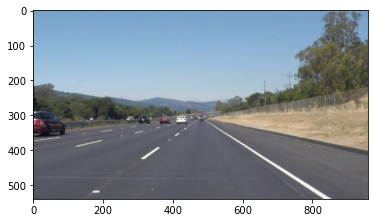

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

In [4]:
images_list = os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

For finding lanes in a given image, using the tools discussed in the previous videos, I am going to follow the following steps:

    1. Filtering out the white and yellow colors from the image
    2. Grayscaling the image
    3. Blurring the image
    4. Detecting Canny edges
    5. Selecting the region of interest
    6. Detecting Hough Lines
    7. Drawing lanes from the detected lines
    
The steps are inspired from the study by Li et al. (https://www.hindawi.com/journals/am/2018/8320207/).

## Helper functions

In [7]:
import math

# For extracting white and yellow colors from the image
def filter_white_yellow_rgb(img):
    # white range - [255, 255, 255]
    white_lower = [210, 210, 210]
    white_upper = [255, 255, 255]
    # yellow range - [255, 255, 0]
    yello_lower = [190, 190, 0  ]
    yello_upper = [255, 255, 255]
    # masks
    white_mask = cv2.inRange(img, white_lower, white_upper)
    yello_mask = cv2.inRange(img, yello_lower, yello_upper)
    total_mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_img = cv2.bitwise_and(img, img, mask = total_mask)
    return masked_img

# Extracting the colours in HLS domain as they are more clearly visible than RGB.
def filter_white_yellow_hls(image):
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white color mask
    # Selecting all the pixels with L ranging from 200 to 255 
    # It represents bright colors (mostly perceived as white).
    white_lower = np.uint8([  0, 200,   0])
    white_upper = np.uint8([255, 255, 255])
    # yellow color mask
    # Selecting Hue such that it covers the Yellow color.
    # As the lightness can vary, we can allow it for a larger range.
    # Tested the ranges on this website: https://hslpicker.com/#fffc42
    yello_lower = np.uint8([ 15,  30, 100])
    yello_upper = np.uint8([ 60, 255, 255])
    # masks
    white_mask = cv2.inRange(converted, white_lower, white_upper)
    yellow_mask = cv2.inRange(converted, yello_lower, yello_upper)
    # combine the mask
    total_mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = total_mask)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def blur_it(img, kernel_size=15):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny_edges(img, low_th = 50, high_th = 150):
    return cv2.Canny(img, low_th, high_th)

def filter_region_of_interest(img):
    height, width = img.shape[:2]
    # range vertices
    left_dwn  = [width*0.05, height*0.95]
    left_up   = [width*0.4 , height*0.6]
    right_up  = [width*0.6 , height*0.6]
    right_dwn = [width*0.95, height*0.95]
    vertices = np.array([[left_dwn, left_up, right_up, right_dwn]], dtype=np.int32)
    # print(len(img.shape), vertices)
    mask = np.zeros_like(img)
    if len(img.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) 
    # show_images([mask])
    img_roi = cv2.bitwise_and(img, mask)
    return img_roi

def hough_lines(roi_canny_image):
    return cv2.HoughLinesP(roi_canny_image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)

def extracting_lanes(lines_list):
    left_lines    = [] # (m, c)
    lwts          = [] # (length,)
    right_lines   = [] # (m, c)
    rwts          = [] # (length,)
    for each_line in lines_list:
        for x1, y1, x2, y2 in each_line:
            if x2 == x1: continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2 + (x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                lwts.append((length))
            else:
                right_lines.append((slope, intercept))
                rwts.append((length))
    # add more weight to longer lines    
    left_lane  = np.dot(lwts,  left_lines) /np.sum(lwts) if len(lwts)>0 else None
    right_lane = np.dot(rwts, right_lines) /np.sum(rwts) if len(rwts)>0 else None
    return left_lane, right_lane # (avg m, avg c), (avg m, avg c)
    
    
def line_mc_to_points(m, c, y1, y2):
    x1 = int((y1 - c) / m)
    x2 = int((y2 - c) / m)
    return ((x1, y1), (x2, y2))
    
def lane_points(y1, y2, lanes):
    points = []
    for each_lane in lanes:
        if each_lane is None:
            continue
        else:
            m, c = each_lane
            points.append(line_mc_to_points(m, c, y1, y2))
    return points
    
def draw_lanes(image, lanes, c =[255, 0, 0], thckness = 20):
    line_image = np.zeros_like(image)
    for line in lanes:
        #print(line)
        cv2.line(line_image, line[0], line[1],  c, thckness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)

def show_images(images, titles = None, cmap=None):
    len_ = len(images)
    rows, cols = 1, len_
    if 3 < len_ < 7:
        rows, cols = 2, (len_ + 1)//2
    elif 7 < len_ < 10:
        rows, cols = (len_ + 1)//3, 3
    elif len_ > 10:
        rows, cols = (len_+1)//2, 2 
    
    print(rows, cols, len_)
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if titles is not None:
            plt.title(titles[i])
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()


In [8]:
def find_lanes_image(image):
    # DETECTING WHITE AND YELLO COLOURS FROM THE IMAGE
    wy_image = filter_white_yellow_hls(image)
    
    # TURNING THE IMAGE INTO GRAY AND BLURRING IT FOR EDGE DETECTION
    gs_image = grayscale(wy_image)
    bl_image = blur_it(gs_image)   
    
    # DETECTING EDGES IN THE IMAGE
    ce_image = canny_edges(bl_image)    
    
    # FILTERING THE ONLY EDGES WHICH EXIST IN THE RANGE OF INTEREST (ROI)
    roi_image = filter_region_of_interest(ce_image)
    
    # EXTRACTING LINES (potential lanes) AMONG THE LINES DETECTED IN THE ROI
    lines_list = hough_lines(roi_image)                # ((x1,y1), (x2,y2))
    if lines_list is None:
        return [wy_image, gs_image, bl_image, ce_image, roi_image]

    # FROM THE HOUGH LINES, SELECTING THE RIGHT AND LEFT LINES
    # WE AVERAGE THE LINES DETECTED FOR RIGHT AND LEFT SIDE SEPARATELY
    # THE WEIGHTS WHILE AVERAGING THE LINES ARE OBTAINED USING THE LENGTHS OF THE LINES.
    # (Since bigger lengths is equivalent to bigger confidence for the line being the correct lane.)
    # FOR WEIGHTED AVERAGING THE LINES, THE LINES ARE CONVERTED INTO (slope (m), intercept (c)) REPRESENTATION.
    lanes = extracting_lanes(lines_list)  # ((m, c), (m, c))
    
    # NOW PLOTTING THE RIGHT AND LEFT LANES ONTO THE IMAGE.
    y1 = roi_image.shape[0]
    y2 = int(y1 * 0.6)
    lanes_pts = lane_points(y1, y2, lanes)
    image_lanes = draw_lanes(image, lanes_pts)
    return [wy_image, gs_image, bl_image, ce_image, roi_image, image_lanes]

2 3 6


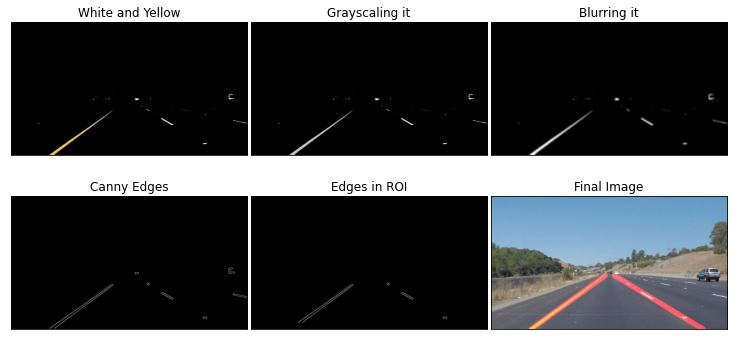

2 3 6


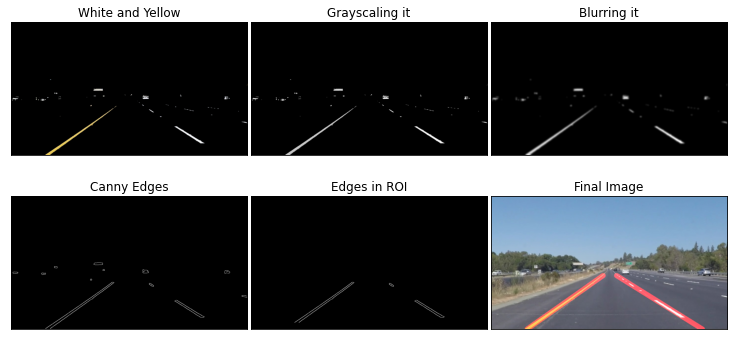

2 3 6


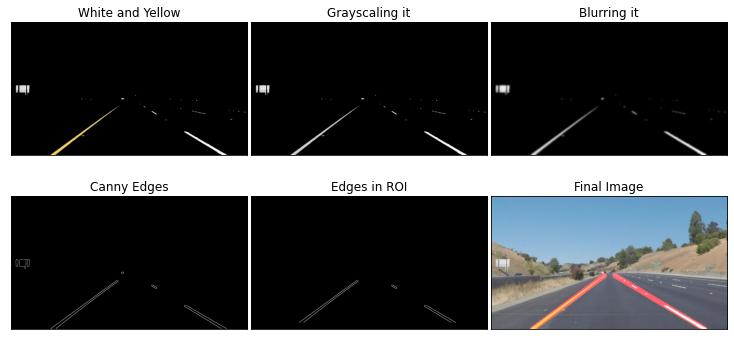

2 3 6


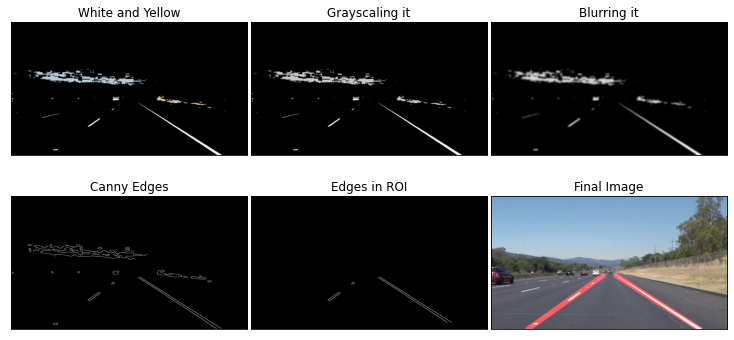

2 3 6


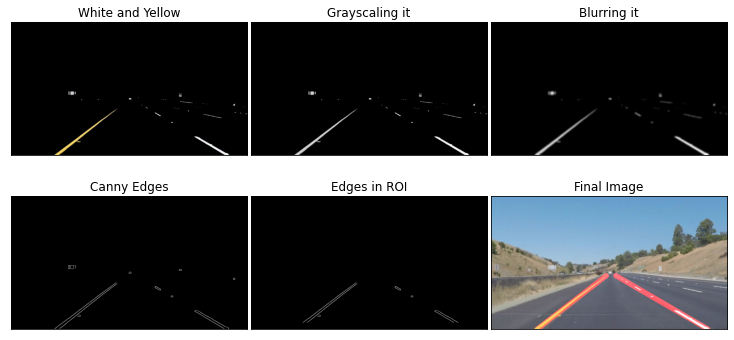

2 3 6


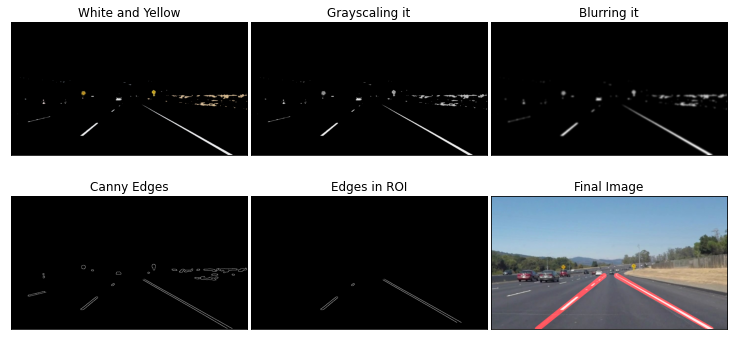

In [9]:
# image = mpimg.imread("test_images/"+images_list[0])
# show_images([image], ["image"])

from PIL import Image

for each in images_list:
    img = mpimg.imread("test_images/"+each)
    result = find_lanes_image(img)
    show_images(result, ["White and Yellow", "Grayscaling it", "Blurring it", "Canny Edges", "Edges in ROI", "Final Image"])
    im = Image.fromarray(result[-1])
    im.save(f"test_images_output/{each}")
    # cv2.imwrite(f"test_images_output/{each}", result[-1])

1 1 1


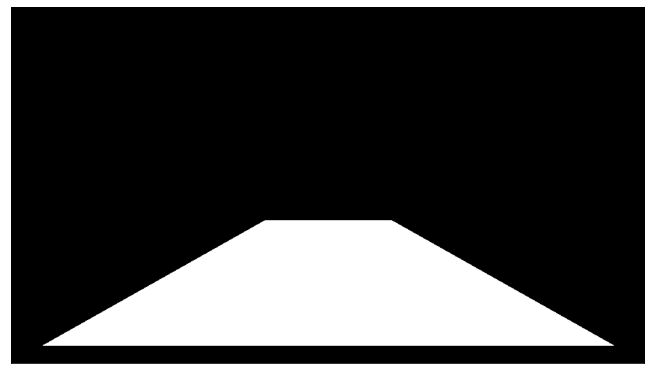

In [10]:
## Observing the ROI

img = mpimg.imread("test_images/"+each)
height, width = img.shape[:2]
# range vertices
left_dwn  = [width*0.05, height*0.95]
left_up   = [width*0.4 , height*0.6]
right_up  = [width*0.6 , height*0.6]
right_dwn = [width*0.95, height*0.95]
vertices = np.array([[left_dwn, left_up, right_up, right_dwn]], dtype=np.int32)
# print(len(img.shape), vertices)
mask = np.zeros_like(img)
if len(img.shape) == 2:
    cv2.fillPoly(mask, vertices, 255)
else:
    cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) 
show_images([mask])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image_lines(image):
    return find_lanes_image(image)[-1]

process_image = process_image_lines

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_lines) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   5%|▍         | 10/221 [00:00<00:02, 91.74it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 3.41 s, sys: 889 ms, total: 4.3 s
Wall time: 2.86 s


Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   5%|▍         | 10/221 [00:00<00:02, 91.50it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 3.2 s, sys: 832 ms, total: 4.03 s
Wall time: 2.66 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|▏         | 10/681 [00:00<00:06, 98.22it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 10 s, sys: 2.57 s, total: 12.6 s
Wall time: 7.87 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [18]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   3%|▎         | 7/251 [00:00<00:03, 67.25it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 6.71 s, sys: 1.85 s, total: 8.56 s
Wall time: 5.78 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))